In [1]:
import jieba
from docx import Document
import requests
import os
import pandas as pd
import numpy as np
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# 读取本地停用词表
stopwords = set(line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').read().splitlines())

In [3]:
# 读取文本数据
def read_texts(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            with open(file_path, encoding='utf-8') as file:
                yield file.read()

In [4]:
directory = "C:/pythonProject/train_model/THUCNews/THUCNews/cn_train_data"
processed_texts = list(read_texts(directory))

In [5]:
def preprocess_chinese_text(text):
    # 使用jieba进行分词和词性标注
    words = jieba.cut_for_search(text, HMM=True)
    
    # 过滤停用词和进行词性选择
    filtered_words = [word for word in words if word not in stopwords and word.strip() and not word.isspace()]  

    return filtered_words

In [6]:
# 对文本进行分词
segmented_texts = [preprocess_chinese_text(text) for text in processed_texts]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIUYIN~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.576 seconds.
Prefix dict has been built successfully.


In [7]:
# 创建字典和语料库
dictionary = corpora.Dictionary(segmented_texts)
corpus = [dictionary.doc2bow(text) for text in segmented_texts]

In [8]:
def lda_model(corpus, dictionary, num_topics=5):
    """训练LDA模型并返回。"""
    # 设置训练LDA模型的参数
    lda = models.ldamulticore.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=30, random_state=42, workers=4)
    return lda

In [9]:
lda = models.ldamulticore.LdaMulticore(corpus, num_topics=35, id2word=dictionary, passes=30, random_state=42, workers=4)

KeyboardInterrupt: 

In [37]:
lda.save('lda_model_35')

In [10]:
def coherence(num_topics, corpus, dictionary, segmented_texts):
    lda = models.ldamulticore.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=30, random_state=42, workers=4)
    coherence_model_lda = models.CoherenceModel(model=lda, texts=segmented_texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

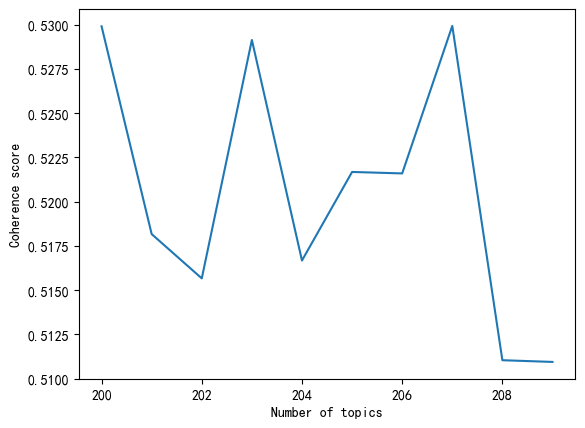

In [11]:
x = range(200,210,1)
y = [coherence(i,corpus, dictionary, segmented_texts) for i in x]
plt.plot(x,y)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.show()

In [34]:
y

[0.5802997007254032,
 0.5649747431355711,
 0.5653470217619219,
 0.5869770578381711,
 0.5883368225333245,
 0.5886584059625369,
 0.569492579643838,
 0.5819812648500603,
 0.5693761727313987,
 0.5591086498087194]

In [35]:
max(zip(x,y),key=lambda pair:pair[1]) 

(35, 0.5886584059625369)

In [18]:
coherence_model_lda = models.CoherenceModel(model=lda, texts=segmented_texts, dictionary=dictionary, coherence='c_v')

In [20]:
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5612039202403832


In [21]:
def read_text_from_docx(file_path):
    document = Document(file_path)
    text = []
    
    for para in document.paragraphs:
        text.append(para.text)
    
    return "\n".join(text)

In [22]:
def process_documents(directory):
    """处理目录下的所有.docx文件，并返回分词结果列表。"""
    documents = []
    documents_name = []
    for filename in os.listdir(directory):
        if filename.endswith(".docx"):
            file_path = os.path.join(directory, filename)
            text = read_text_from_docx(file_path)
            segmented_text = preprocess_chinese_text(text)
            documents.append(segmented_text)
            documents_name.append(filename)
    return documents, documents_name

In [23]:
directory_doc = "C:/pythonProject/PageRank/技术1"

In [19]:
documents, documents_name = process_documents(directory_doc)

In [20]:
# 对每个文件进行处理和主题分配
for filename in os.listdir(directory_doc):
    if filename.endswith('.docx'):
        file_path = os.path.join(directory_doc, filename)
        text = read_text_from_docx(file_path)
        processed_text = preprocess_chinese_text(text)
        bow = dictionary.doc2bow(processed_text)
        topics = lda.get_document_topics(bow)
        print(f'File: {filename}')
        print('Topics:', topics)

File: 01_技术革命.docx
Topics: [(1, 0.84779894), (99, 0.08210686)]
File: 02_现代技术的发展.docx
Topics: [(1, 0.37448156), (4, 0.09950482), (48, 0.2611513), (99, 0.08649062), (103, 0.09171068)]
File: 03_技术与教育.docx
Topics: [(1, 0.22994834), (8, 0.054648455), (21, 0.24826525), (41, 0.055805694), (60, 0.18531199), (72, 0.09795661), (103, 0.07613119)]
File: 04_技术在医疗中的应用.docx
Topics: [(36, 0.12669182), (43, 0.32016718), (66, 0.1738602), (80, 0.1363828), (99, 0.09727951), (104, 0.08260344)]
File: 05_技术进步对经济的推动.docx
Topics: [(1, 0.5093873), (42, 0.28538418), (90, 0.107573226)]
File: 06_技术和社会变革.docx
Topics: [(21, 0.36134225), (48, 0.10032763), (74, 0.3024847), (83, 0.15560025)]
File: 07_技术与环境保护.docx
Topics: [(25, 0.059553143), (43, 0.07333907), (53, 0.17204337), (73, 0.32718754), (78, 0.07873122), (88, 0.21990861)]
File: 08_技术在农业中的应用.docx
Topics: [(1, 0.29993975), (10, 0.08005102), (56, 0.09338113), (60, 0.12966757), (66, 0.22223967), (76, 0.101048306)]
File: 09_智能技术的未来.docx
Topics: [(4, 0.09148945), (60,

In [22]:
### 获取每个文档的主题分布
def get_topic_distribution(lda, corpus):
    topic_distribution = []
    for doc in corpus:
        topic_distribution.append(lda.get_document_topics(doc,minimum_probability=0.0))
    return topic_distribution

In [23]:
topic_distribution = get_topic_distribution(lda, corpus)

In [24]:
topic_distribution

[[(0, 0.36281243),
  (1, 3.891733e-05),
  (2, 0.024715032),
  (3, 3.891733e-05),
  (4, 3.891733e-05),
  (5, 3.891733e-05),
  (6, 3.891733e-05),
  (7, 3.891733e-05),
  (8, 3.891733e-05),
  (9, 3.891733e-05),
  (10, 3.891733e-05),
  (11, 3.891733e-05),
  (12, 3.891733e-05),
  (13, 3.891733e-05),
  (14, 0.113918886),
  (15, 3.891733e-05),
  (16, 0.2537436),
  (17, 3.891733e-05),
  (18, 3.891733e-05),
  (19, 3.891733e-05),
  (20, 3.891733e-05),
  (21, 3.891733e-05),
  (22, 3.891733e-05),
  (23, 3.891733e-05),
  (24, 3.891733e-05),
  (25, 3.891733e-05),
  (26, 3.891733e-05),
  (27, 3.891733e-05),
  (28, 0.08781062),
  (29, 3.891733e-05),
  (30, 3.891733e-05),
  (31, 3.891733e-05),
  (32, 3.891733e-05),
  (33, 3.891733e-05),
  (34, 3.891733e-05),
  (35, 3.891733e-05),
  (36, 3.891733e-05),
  (37, 3.891733e-05),
  (38, 3.891733e-05),
  (39, 3.891733e-05),
  (40, 3.891733e-05),
  (41, 3.891733e-05),
  (42, 3.891733e-05),
  (43, 0.0357719),
  (44, 3.891733e-05),
  (45, 3.891733e-05),
  (46, 0.0